# [AVES](https://github.com/earthspecies/aves) for supervised classification

This notebook shows how to learn a machine learning classifier from a small labeled dataset of animal vocalizations, by fine-tuning AVES. AVES is a self-supervised, transformer-based audio representation model for encoding animal vocalizations. You can find the Github repository for AVES [here](https://github.com/earthspecies/aves).

If you want to find clusters in a dataset without labels, see [this notebook](https://colab.research.google.com/drive/1dtBorrZkEfsn90Mj9SETF2DFAY9sjCqe?usp=sharing) instead.

## Creating the dataset

We will use an [adult zebra finch dataset](https://figshare.com/articles/dataset/Vocal_repertoires_from_adult_and_chick_male_and_female_zebra_finches_Taeniopygia_guttata_/11905533/1) reported in the following papers:
- Elie JE and Theunissen FE. The vocal repertoire of the domesticated zebra finch: a data driven approach to decipher the information-bearing acoustic features of communication signals. Animal Cognition. 2016. 19(2) 285-315 doi: 10.1007/s10071-015-0933-6 [OA eScholarship]
- Elie JE and Theunissen FE. Zebra Finches identify individuals using vocal signatures unique to each call type. Nature communication. 2018. 9:4026. doi:10.1038/s41467-018-06394-9 [OA]

This dataset contains 2911 signals overall, made by 34 individuals. The signals are labeled with 12 call types, which were labeled on the basis of the zebra finch's behavior while the call was emitted.

We download the data and fix some naming inconsistencies before parsing the data. We also omit one class because it only contained one individual.

In [ ]:
%%capture
# @title
!wget https://figshare.com/ndownloader/files/21833430
!unzip 21833430

#Fix naming inconsistencies
!mv GraLbl0457_110407_TetC-03.wav GraLbl0457_110407-TetC-03.wav
!mv GraLbl0457_110407_TetC-04.wav GraLbl0457_110407-TetC-04.wav
!mv GreRas2400_110615_DC-01.wav GreRas2400_110615-DC-01.wav
!mv GreRas2400_110615_DC-02.wav GreRas2400_110615-DC-02.wav
!mv GreRas2400_110615_TetC-01.wav GreRas2400_110615-TetC-01.wav
!mv GreRas2400_110615_TetC-02.wav GreRas2400_110615-TetC-02.wav
!mv GreRas2400_110615_TetC-03.wav GreRas2400_110615-TetC-03.wav
!mv GreRas2400_110615_TetC-04.wav GreRas2400_110615-TetC-04.wav
!mv GreRas2400_110615_TetC-05.wav GreRas2400_110615-TetC-05.wav
!mv GreRas2400_110615_TetC-06.wav GreRas2400_110615-TetC-06.wav
!mv GreRas2400_110615_TetC-07.wav GreRas2400_110615-TetC-07.wav
!mv GreRas2400_110615_TetC-08.wav GreRas2400_110615-TetC-08.wav
!mv GreRas2400_110615_TetC-09.wav GreRas2400_110615-TetC-09.wav
!mv GreRas2400_110615_TetC-10.wav GreRas2400_110615-TetC-10.wav
!mv GreRas2400_110615_TetC-20.wav GreRas2400_110615-TetC-20.wav
!mv GreRas2400_110615_TetC-30.wav GreRas2400_110615-TetC-30.wav
!mv GreRas2400_110615_TetC-11.wav GreRas2400_110615-TetC-11.wav
!mv GreRas2400_110615_TetC-12.wav GreRas2400_110615-TetC-12.wav
!mv GreRas2400_110615_TetC-13.wav GreRas2400_110615-TetC-13.wav
!mv GreRas2400_110615_TetC-14.wav GreRas2400_110615-TetC-14.wav
!mv GreRas2400_110615_TetC-15.wav GreRas2400_110615-TetC-15.wav
!mv GreRas2400_110615_TetC-16.wav GreRas2400_110615-TetC-16.wav
!mv GreRas2400_110615_TetC-17.wav GreRas2400_110615-TetC-17.wav
!mv GreRas2400_110615_TetC-18.wav GreRas2400_110615-TetC-18.wav
!mv GreRas2400_110615_TetC-19.wav GreRas2400_110615-TetC-19.wav
!mv GreRas2400_110615_TetC-21.wav GreRas2400_110615-TetC-21.wav
!mv GreRas2400_110615_TetC-22.wav GreRas2400_110615-TetC-22.wav
!mv GreRas2400_110615_TetC-23.wav GreRas2400_110615-TetC-23.wav
!mv GreRas2400_110615_TetC-24.wav GreRas2400_110615-TetC-24.wav
!mv GreRas2400_110615_TetC-25.wav GreRas2400_110615-TetC-25.wav
!mv GreRas2400_110615_TetC-26.wav GreRas2400_110615-TetC-26.wav
!mv GreRas2400_110615_TetC-27.wav GreRas2400_110615-TetC-27.wav
!mv GreRas2400_110615_TetC-28.wav GreRas2400_110615-TetC-28.wav
!mv GreRas2400_110615_TetC-29.wav GreRas2400_110615-TetC-29.wav
!mv GreRas2400_110615_TetC-31.wav GreRas2400_110615-TetC-31.wav
!mv GreRas2400_110615_TetC-32.wav GreRas2400_110615-TetC-32.wav
!mv GreRas2400_110615_TetC-33.wav GreRas2400_110615-TetC-33.wav
!mv GreRas2400_110615_TetC-34.wav GreRas2400_110615-TetC-34.wav

In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import seaborn as sns

In [2]:
data_dir = "/data/"
fps = sorted(glob(os.path.join(data_dir, '*.wav')))

individuals = []
recording_dates = []
call_types = []
file_names = []
fps_sub = []

for fp in fps:
  bn = os.path.basename(fp)

  individual = bn.split("_")[0]
  if "Unknown" in individual:
    # exclude unknown individuals
    continue

  recording_date = bn.split("_")[1].split("-")[0]
  call_type = bn.split("-")[1][:2]
  if "WC" in call_type:
    #Only present for one individual, so we omit
    continue

  individuals.append(individual)
  recording_dates.append(recording_date)
  call_types.append(call_type)
  file_names.append(bn)
  fps_sub.append(fp)

df = pd.DataFrame({"filename" : file_names, "filepath" : fps_sub, "individual" : individuals, "recording_date" : recording_dates, "call_type" : call_types})

In [3]:
print("The number of signals is: ", len(df))
print("The number of individuals is: ", len(df["individual"].unique()))
print("The number of call types is: ", len(df["call_type"].unique()))

The number of signals is:  0
The number of individuals is:  0
The number of call types is:  0


Next, we need to make a train and test set. We will train our classifier only on signals made by half of the individuals (train set). We will then test the classifier on signals made by the remaining individuals (test set), to see how well the classifier can perform for individuals it has never seen before.

In [10]:
np.random.seed(3)
randomized_individuals = np.random.permutation(df["individual"].unique())
train_set = randomized_individuals[:17]
df["partition"] = df.apply(lambda row: "train" if row["individual"] in train_set else "test", axis=1)

Now we can visualize the distribution of signals into train and test set.

<Axes: >

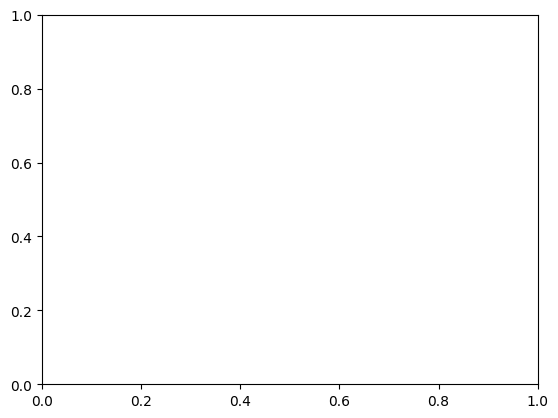

In [5]:
sns.countplot(x='call_type', hue="partition", data=df)

## Creating the dataloader

Now we will use this pandas dataframe to create a pytorch dataloader.

In [6]:
import torch
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [7]:
class Vox(Dataset):
    def __init__(self, dataset_dataframe, is_train, audio_sr, duration_sec, annotation_name):
        """ Dataset for vocalization classification with AVES

        Input
        -----
        dataset_dataframe (pandas dataframe): indicating the filepath, annotations and partition of a signal
        is_train (bool): True if in train set
        audio_sr (int): sampling rate expected by network
        duration_sec (float): pad/cut all clips to this duration to enable batching
        annotation_name (str): string corresponding to the annotation columns in the dataframe, e.g. "call_type"
        """
        super().__init__()
        self.audio_sr = audio_sr
        self.duration_sec = duration_sec
        self.dataset_partition = "train" if is_train else "test"
        self.annotation_name = annotation_name
        # Turn class annotations into integers from 0 - n_classes-1
        class_annotations = pd.Categorical(dataset_dataframe[annotation_name])
        self.classes = class_annotations.categories
        dataset_dataframe = dataset_dataframe.copy()
        dataset_dataframe[annotation_name + "_int"] = class_annotations.codes
        self.dataset_info = dataset_dataframe[dataset_dataframe["partition"] == self.dataset_partition]

    def __len__(self):
        return len(self.dataset_info)

    def get_one_item(self, idx):
      """ Load base audio """
      row = self.dataset_info.iloc[idx]
      x, sr = torchaudio.load(row["filepath"])
      if len(x.size()) == 2:
          x = x[0, :]
      if sr != self.audio_sr:
          x = torchaudio.functional.resample(x, sr, self.audio_sr)
      return x, row

    def pad_to_duration(self, x):
        """ Pad or clip x to a given duration """
        assert len(x.size()) == 1
        x_duration = x.size(0) / float(self.audio_sr)
        max_samples = int(self.audio_sr * self.duration_sec)
        if x_duration == self.duration_sec:
            return x
        elif x_duration < self.duration_sec:
            x = F.pad(x , (0, max_samples - x.size(0)), mode='constant')
            return x
        else:
            return x[:max_samples]

    def __getitem__(self, idx):
        x, row = self.get_one_item(idx)
        x = self.pad_to_duration(x)
        out = {"x" : x, "filepath" : row['filepath'], "filename" : row['filename']}
        out[self.annotation_name + "_str"] = row[self.annotation_name]
        out[self.annotation_name] = row[self.annotation_name + "_int"]
        return out

def get_dataloader(dataset_dataframe, is_train, audio_sr, duration_sec, labels, batch_size):
    return DataLoader(
            Vox(dataset_dataframe, is_train, audio_sr, duration_sec, labels),
            batch_size=batch_size,
            shuffle=is_train,
            drop_last=is_train
        )

Now let's visualize some examples from the training set

In [8]:
import librosa
import matplotlib.pyplot as plt


  Dataset with 0 datapoints
  Classes: Index([], dtype='float64')



IndexError: single positional indexer is out-of-bounds

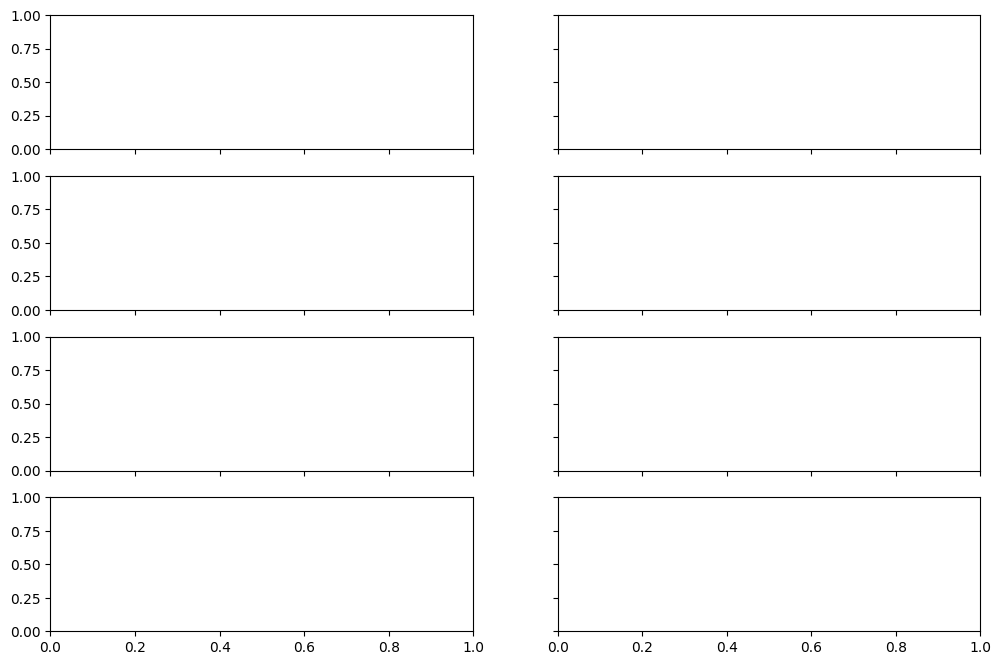

In [9]:
dataset_viz = Vox(df, True, 16000, 1.0, "call_type")
print(f"""
  Dataset with {len(dataset_viz)} datapoints
  Classes: {dataset_viz.classes}
""")
n_fft = 512
fig, axs = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(12,8))
ax_idx = 0
for datapoint_idx in [10, 12, 8, 9, 20, 21, 45, 46]:
  ax = axs.flatten()[ax_idx]
  datapoint = dataset_viz[datapoint_idx]
  D = librosa.stft(datapoint["x"].numpy(), n_fft=n_fft)
  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

  librosa.display.specshow(S_db, y_axis='linear', sr=16000,
                            x_axis='time', ax=ax, n_fft=n_fft)
  ax.set_title(datapoint["call_type_str"])
  ax_idx+=1
plt.tight_layout()

We can see that the spectrograms of different call types vary, although some call types appear more similar to each other (e.g., `Ne` and `Te` look more similar to each other than `DC` and `Ag`).

## Setting up the model

We start by downloading the model weights.

In [ ]:
!wget https://storage.googleapis.com/esp-public-files/ported_aves/aves-base-bio.torchaudio.pt
!wget https://storage.googleapis.com/esp-public-files/ported_aves/aves-base-bio.torchaudio.model_config.json

--2023-09-09 10:33:08--  https://storage.googleapis.com/esp-public-files/ported_aves/aves-base-bio.torchaudio.pt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.171.207, 173.194.74.207, 173.194.192.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.171.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377570545 (360M) [application/octet-stream]
Saving to: ‘aves-base-bio.torchaudio.pt’

aves-base-bio.torch 100%[===================>] 360.08M   151MB/s    in 2.4s    

2023-09-09 10:33:11 (151 MB/s) - ‘aves-base-bio.torchaudio.pt’ saved [377570545/377570545]

--2023-09-09 10:33:11--  https://storage.googleapis.com/esp-public-files/ported_aves/aves-base-bio.torchaudio.model_config.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.171.207, 173.194.74.207, 173.194.192.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.171.207|:443... connected.
HTTP request sent, aw

In [ ]:
from torchaudio.models import wav2vec2_model
import json

The AVES-based classifier will be made up of three overall parts:
- `feature_extractor`: the first set of convolutional layers
- `encoder`: a transformer which outputs 768-dimensional embedding vectors
- `classification_head`: a linear layer which transforms the embedding into class logits

The first two parts have already been trained. The third part, the `classification_head` must be fine-tuned for your dataset.

In [ ]:
class AvesClassifier(nn.Module):
    """ Uses AVES Hubert to embed sounds and classify """
    def __init__(self, config_path, model_path, n_classes, trainable, embedding_dim=768):
        super().__init__()
        # reference: https://pytorch.org/audio/stable/_modules/torchaudio/models/wav2vec2/utils/import_fairseq.html
        self.config = self.load_config(config_path)
        self.model = wav2vec2_model(**self.config, aux_num_out=None)
        self.model.load_state_dict(torch.load(model_path))
        # Freeze the AVES network
        self.trainable = trainable
        freeze_embedding_weights(self.model, trainable)
        # We will only train the classifier head
        self.classifier_head = nn.Linear(in_features=embedding_dim, out_features=n_classes)
        self.audio_sr = 16000

    def load_config(self, config_path):
        with open(config_path, 'r') as ff:
            obj = json.load(ff)
        return obj

    def forward(self, sig):
        """
        Input
          sig (Tensor): (batch, time)
        Returns
          mean_embedding (Tensor): (batch, output_dim)
          logits (Tensor): (batch, n_classes)
        """
        # extract_feature in the sorchaudio version will output all 12 layers' output, -1 to select the final one
        out = self.model.extract_features(sig)[0][-1]
        mean_embedding = out.mean(dim=1) #over time
        logits = self.classifier_head(mean_embedding)
        return mean_embedding, logits

**Freezing weights**: we will not fine-tune the pretrained AVES network because this would lead to overfitting. This means we will freeze the weights both for the early convolutional layers, and the transformer. We provide the following helper functions for typical use cases. These functions are specific to the torchaudio port version of this model, and may need to be changed if you use a different way of loading in the model.

In [ ]:
# Code to use while initially setting up the model
def freeze_embedding_weights(model, trainable):
  """ Freeze weights in AVES embeddings for classification """
  # The convolutional layers should never be trainable
  model.feature_extractor.requires_grad_(False)
  model.feature_extractor.eval()
  # The transformers are optionally trainable
  for param in model.encoder.parameters():
    param.requires_grad = trainable
  if not trainable:
    # We also set layers without params (like dropout) to eval mode, so they do not change
    model.encoder.eval()


# Code to use during training loop, to switch between eval and train mode
def set_eval_aves(model):
  """ Set AVES-based classifier to eval mode. Takes into account whether we are training transformers """
  model.classifier_head.eval()
  model.model.encoder.eval()

def set_train_aves(model):
  """ Set AVES-based classifier to train mode. Takes into account whether we are training transformers """
  # Always train the classifier head
  model.classifier_head.train()
  # Optionally train the transformer of the model
  if model.trainable:
      model.model.encoder.train()


## Training and evaluation

First we write a typical train loop: loading in the data, passing it through our model, computing the loss, and then applying the gradients.

In [ ]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, loss_function):
    """ Update model based on supervised classification task """

    set_train_aves(model)
    loss_function = nn.CrossEntropyLoss()

    epoch_losses = []
    iterator = tqdm(dataloader)
    for i, batch_dict in enumerate(iterator):
        optimizer.zero_grad()
        if torch.cuda.is_available():
          batch_dict["x"] = batch_dict["x"].cuda()
          batch_dict[dataloader.dataset.annotation_name] = batch_dict[dataloader.dataset.annotation_name].cuda()

        embedding, logits = model(batch_dict["x"])
        loss = loss_function(logits, batch_dict[dataloader.dataset.annotation_name].to(torch.long))

        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        if len(epoch_losses) > 10:
          iterator.set_description(f"Train loss: {np.mean(epoch_losses[-10:]):.3f}")

    return epoch_losses

After one epoch, we will test the model. For this, we loop over all examples in the test set and obtain predictions. In addition to computing the cross entropy loss on the test set, we also obtain classification metrics such as the confusion matrix and F1 scores.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def test_one_epoch(model, dataloader, loss_function, epoch_idx):
  """ Obtain loss and F1 scores on test set """

  set_eval_aves(model)

  # Obtain predictions
  all_losses = []
  all_predictions = []
  with torch.no_grad():
    for i, batch_dict in enumerate(dataloader):
        if torch.cuda.is_available():
          batch_dict["x"] = batch_dict["x"].cuda()
          batch_dict[dataloader.dataset.annotation_name] = batch_dict[dataloader.dataset.annotation_name].cuda()
        embedding, logits = model(batch_dict["x"])
        all_losses.append(loss_function(logits, batch_dict[dataloader.dataset.annotation_name].to(torch.long)))
        all_predictions.append(logits.argmax(1))

  # Format predictions and annotations
  all_losses = torch.stack(all_losses)
  all_predictions = torch.cat(all_predictions).cpu().numpy()
  all_annotations = dataloader.dataset.dataset_info[dataloader.dataset.annotation_name + "_int"].to_numpy() # since dataloader shuffle = False
  # Get confusion matrix
  cm = confusion_matrix(all_annotations, all_predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataloader.dataset.classes)
  disp.plot()
  disp.ax_.set_title(f"Test epoch {epoch_idx}")
  # Compute F1
  f1_scores = f1_score(all_annotations, all_predictions, average=None)
  macro_average_f1 = f1_score(all_annotations, all_predictions, average="macro")
  # Report
  print(f"Mean test loss: {all_losses.mean():.3f}, Macro-average F1: {macro_average_f1:.3f}")
  print("F1 by class:")
  print({k: np.round(s,decimals=4) for (k,s) in zip(dataloader.dataset.classes, f1_scores)})
  return

Finally we put it all together into a training loop.

In [ ]:
def run(
      dataset_dataframe,
      model_path,
      model_config_path,
      duration_sec,
      annotation_name,
      learning_rate,
      batch_size,
      n_epochs,
      aves_sr = 16000
      ):

  print("Setting up dataloaders")
  train_dataloader = get_dataloader(dataset_dataframe, True, aves_sr, duration_sec, annotation_name, batch_size)
  test_dataloader = get_dataloader(dataset_dataframe, False, aves_sr, duration_sec, annotation_name, batch_size)

  print("Setting up model")
  model = AvesClassifier(model_config_path, model_path, len(train_dataloader.dataset.classes), False)
  if torch.cuda.is_available():
    model.cuda()

  print("Setting up optimizers")
  optimizer = torch.optim.Adam(model.classifier_head.parameters(), lr=learning_rate)

  print("Setting up loss function")
  loss_function = nn.CrossEntropyLoss()

  for epoch_idx in range(n_epochs):
    print(f"~~ Training epoch {epoch_idx}")
    train_one_epoch(model, train_dataloader, optimizer, loss_function)
    print(f"~~ Testing epoch {epoch_idx}")
    test_one_epoch(model, test_dataloader, loss_function, epoch_idx)

  return

Let's see how it does.

Setting up dataloaders
Setting up model
Setting up optimizers
Setting up loss function
~~ Training epoch 0


Train loss: 1.137: 100%|██████████| 86/86 [00:17<00:00,  4.94it/s]


~~ Testing epoch 0
Mean test loss: 1.180, Macro-average F1: 0.398
F1 by class:
{'Ag': 0.2545, 'Be': 0.3333, 'DC': 0.727, 'Di': 0.0, 'LT': 0.0, 'Ne': 0.6348, 'So': 0.9262, 'Te': 0.7156, 'Th': 0.5093, 'Tu': 0.0, 'Wh': 0.2807}
~~ Training epoch 1


Train loss: 0.868: 100%|██████████| 86/86 [00:09<00:00,  8.83it/s]


~~ Testing epoch 1
Mean test loss: 0.965, Macro-average F1: 0.546
F1 by class:
{'Ag': 0.7702, 'Be': 0.8889, 'DC': 0.8517, 'Di': 0.0, 'LT': 0.0, 'Ne': 0.6653, 'So': 0.9504, 'Te': 0.755, 'Th': 0.5241, 'Tu': 0.2454, 'Wh': 0.3571}
~~ Training epoch 2


Train loss: 0.732: 100%|██████████| 86/86 [00:09<00:00,  8.83it/s]


~~ Testing epoch 2
Mean test loss: 0.897, Macro-average F1: 0.573
F1 by class:
{'Ag': 0.8075, 'Be': 0.9474, 'DC': 0.8794, 'Di': 0.0, 'LT': 0.0, 'Ne': 0.6531, 'So': 0.964, 'Te': 0.7595, 'Th': 0.6075, 'Tu': 0.0826, 'Wh': 0.6027}
~~ Training epoch 3


Train loss: 0.628: 100%|██████████| 86/86 [00:10<00:00,  8.16it/s]


~~ Testing epoch 3
Mean test loss: 0.797, Macro-average F1: 0.604
F1 by class:
{'Ag': 0.8333, 'Be': 0.9474, 'DC': 0.9155, 'Di': 0.0, 'LT': 0.0, 'Ne': 0.6803, 'So': 0.9565, 'Te': 0.8219, 'Th': 0.6288, 'Tu': 0.3676, 'Wh': 0.4923}
~~ Training epoch 4


Train loss: 0.607: 100%|██████████| 86/86 [00:10<00:00,  8.49it/s]


~~ Testing epoch 4
Mean test loss: 0.776, Macro-average F1: 0.607
F1 by class:
{'Ag': 0.8313, 'Be': 0.9474, 'DC': 0.9131, 'Di': 0.0, 'LT': 0.0, 'Ne': 0.6573, 'So': 0.964, 'Te': 0.8351, 'Th': 0.5985, 'Tu': 0.3012, 'Wh': 0.6292}
~~ Training epoch 5


Train loss: 0.521: 100%|██████████| 86/86 [00:10<00:00,  8.52it/s]


~~ Testing epoch 5
Mean test loss: 0.782, Macro-average F1: 0.616
F1 by class:
{'Ag': 0.8242, 'Be': 1.0, 'DC': 0.9262, 'Di': 0.0, 'LT': 0.2857, 'Ne': 0.678, 'So': 0.9489, 'Te': 0.8155, 'Th': 0.5687, 'Tu': 0.0826, 'Wh': 0.641}
~~ Training epoch 6


Train loss: 0.511: 100%|██████████| 86/86 [00:10<00:00,  8.39it/s]


~~ Testing epoch 6
Mean test loss: 0.709, Macro-average F1: 0.632
F1 by class:
{'Ag': 0.8652, 'Be': 0.9524, 'DC': 0.932, 'Di': 0.0, 'LT': 0.2857, 'Ne': 0.6652, 'So': 0.9635, 'Te': 0.8192, 'Th': 0.5174, 'Tu': 0.395, 'Wh': 0.5538}
~~ Training epoch 7


Train loss: 0.487: 100%|██████████| 86/86 [00:10<00:00,  8.43it/s]


~~ Testing epoch 7
Mean test loss: 0.703, Macro-average F1: 0.655
F1 by class:
{'Ag': 0.8488, 'Be': 0.9524, 'DC': 0.9395, 'Di': 0.0, 'LT': 0.5, 'Ne': 0.6914, 'So': 0.9481, 'Te': 0.83, 'Th': 0.6105, 'Tu': 0.2676, 'Wh': 0.6176}
~~ Training epoch 8


Train loss: 0.549: 100%|██████████| 86/86 [00:10<00:00,  8.38it/s]


~~ Testing epoch 8
Mean test loss: 0.721, Macro-average F1: 0.653
F1 by class:
{'Ag': 0.8721, 'Be': 0.9524, 'DC': 0.9303, 'Di': 0.0, 'LT': 0.5, 'Ne': 0.6375, 'So': 0.9481, 'Te': 0.8499, 'Th': 0.5643, 'Tu': 0.2907, 'Wh': 0.6408}
~~ Training epoch 9


Train loss: 0.478: 100%|██████████| 86/86 [00:10<00:00,  8.42it/s]


~~ Testing epoch 9
Mean test loss: 0.676, Macro-average F1: 0.665
F1 by class:
{'Ag': 0.8827, 'Be': 0.9524, 'DC': 0.9417, 'Di': 0.0, 'LT': 0.5, 'Ne': 0.7063, 'So': 0.9481, 'Te': 0.8417, 'Th': 0.6316, 'Tu': 0.2897, 'Wh': 0.6176}


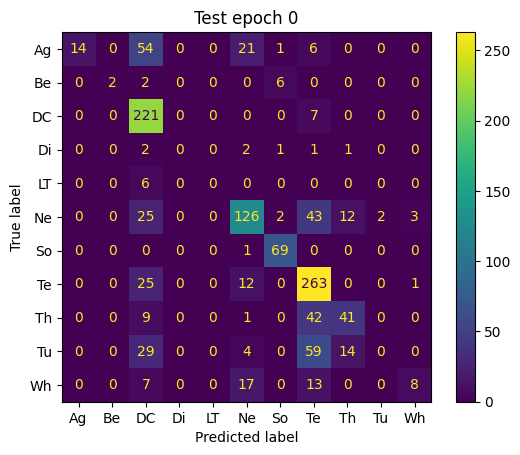

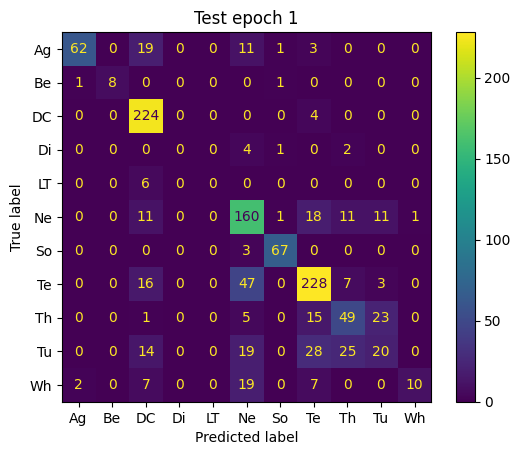

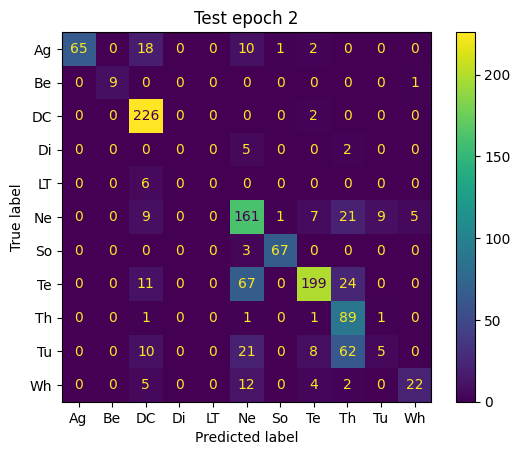

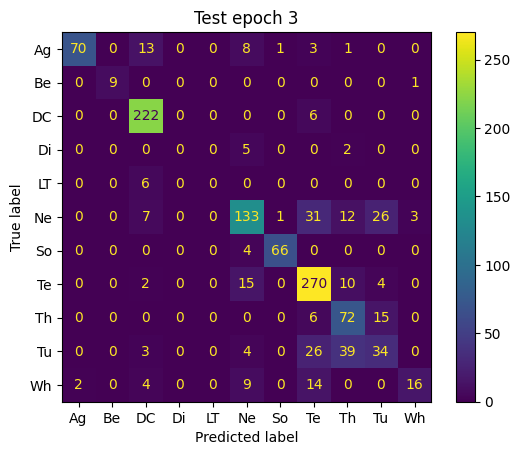

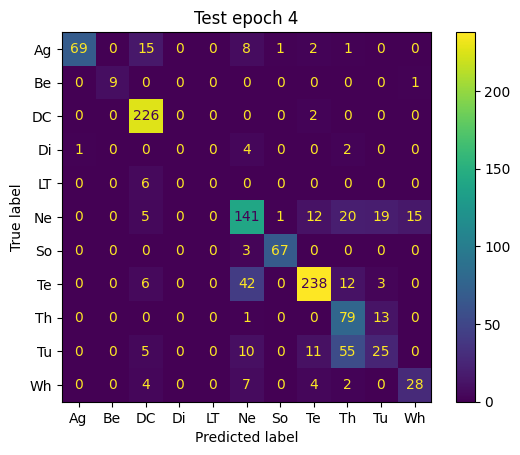

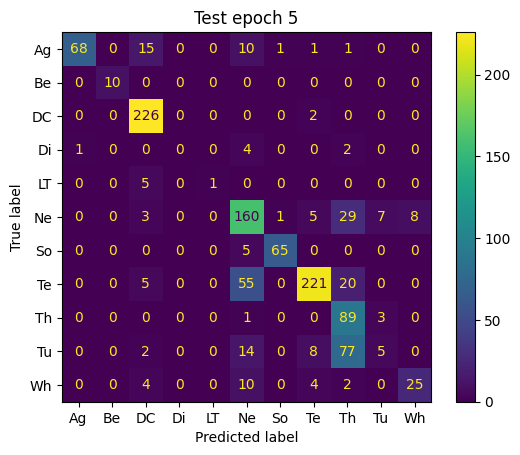

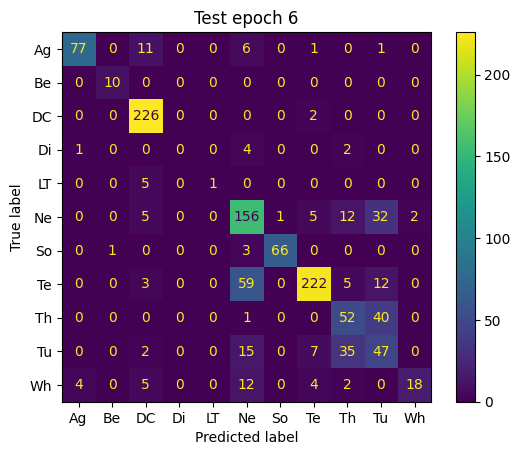

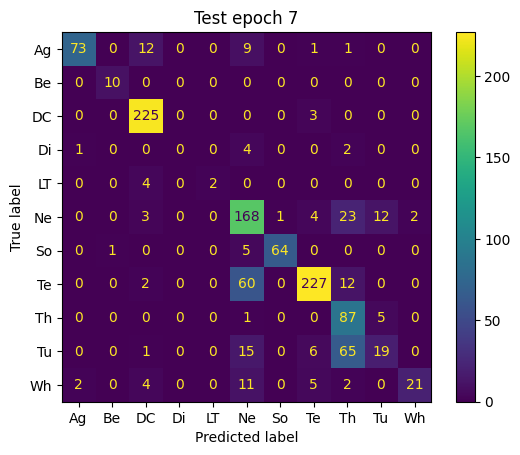

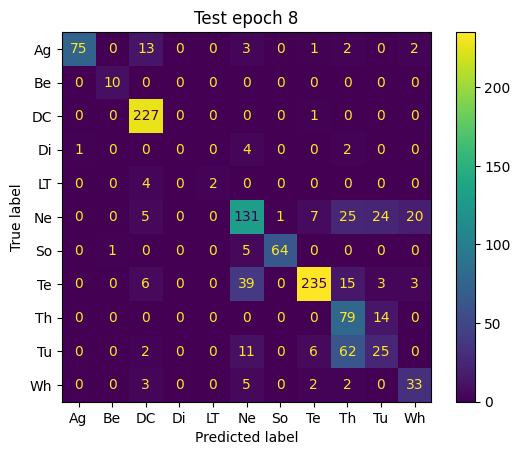

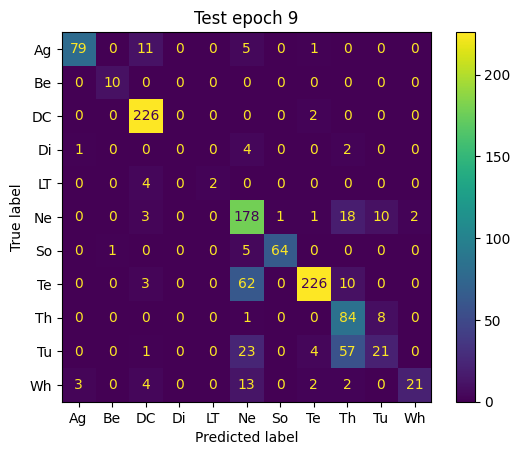

In [ ]:
run(
      dataset_dataframe=df,
      model_path="/content/aves-base-bio.torchaudio.pt",
      model_config_path="/content/aves-base-bio.torchaudio.model_config.json",
      duration_sec=1.0,
      annotation_name="call_type",
      learning_rate=1e-3,
      batch_size=20,
      n_epochs=10
    )

We can see that the model achieves decent performance, although some classes remain confusable, such as `Ne`, `Te`, `Th` and `Tu`. This is intuitive based on the spectrograms we plotted earlier. Performance could be improved by training longer, adjusting hyperparameters, etc.